# Project 4A

In [1]:
import numpy as np
import numpy.ma as ma
import skimage as sk
import skimage.io as skio
import cv2
import json
import matplotlib.pyplot as plt
from scipy.interpolate import griddata as griddata
from scipy.ndimage import distance_transform_edt as distance_transform_edt
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from skimage.feature import corner_harris, peak_local_max

### Part 2: Recover Homographies

In [2]:
def computeH(im1_pts, im2_pts):
    # im1_pts, im2_pts are (n, 2) matrices
    assert im1_pts.shape[0] >= 4, "Requires at least 4 corresponding points"
    assert im1_pts.shape[0] == im2_pts.shape[0], "Requires the same number of corresponding points"

    n = im1_pts.shape[0]
    A = np.zeros((2*n, 8))
    b = np.zeros((2*n, 1))

    for i in range(n):
        x1, y1 = im1_pts[i]
        x_new, y_new = im2_pts[i]
        
        # setting up the linear system of equations
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x1*x_new, -y1*x_new]
        A[2*i+1] = [0, 0, 0, x1, y1, 1, -x1*y_new, -y1*y_new]
        
        b[2*i] = x_new
        b[2*i+1] = y_new

    # Solve for h using least-squares
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Reshape h into a 3x3 matrix and set the bottom-right entry to 1
    h = np.append(h, 1)
    h = h.reshape((3, 3))

    return h


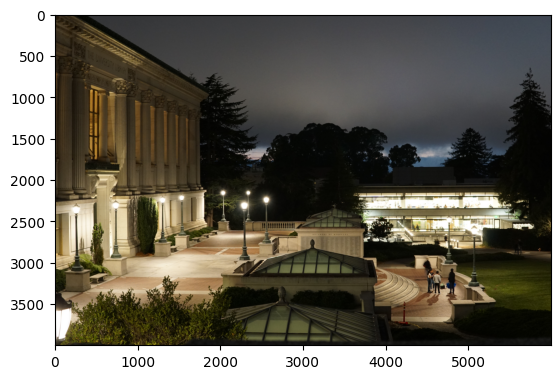

In [3]:
# name of the input file
imname = './source_jpg/glade_1.jpg'

# read in the image
im1 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)

imgplot = plt.imshow(im1)

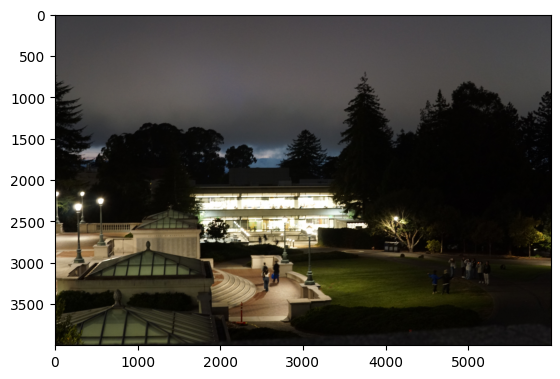

In [4]:
# name of the input file
imname = './source_jpg/glade_2.jpg'

# read in the image
im2 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)

imgplot = plt.imshow(im2)

In [5]:
# correspondance points
# name of the input file
f = open('glade_1_glade_2.json')

correspondances = json.load(f)

im1_points = np.array(correspondances["im1Points"])
im2_points = np.array(correspondances["im2Points"])

In [6]:
H = computeH(im1_points, im2_points)
print(H)

[[ 1.04339653e+00 -1.49099817e-02 -2.06002403e+03]
 [ 1.44797194e-02  1.00064276e+00  1.38809798e-02]
 [ 1.18877569e-05 -9.34788008e-06  1.00000000e+00]]


### Part 3: Warp the Images

In [4]:
def warpImage(im, H):
    # Get new bounding box
    corners = np.vstack([[0, 0, im.shape[1]-1, im.shape[1]-1], [0, im.shape[0]-1, im.shape[0]-1, 0], np.ones(4)]) # (x, y, 1)
    new_corners = H @ corners
    new_corners /= new_corners[2, :] # (x, y, 1)
    max_x, min_x = max(im.shape[1], int(np.ceil(new_corners[0].max()))), min(0, int(np.floor(new_corners[0].min())))
    max_y, min_y = max(im.shape[0], int(np.ceil(new_corners[1].max()))), min(0, int(np.floor(new_corners[1].min())))

    # Empty Canvas to output image
    canvas = np.zeros((max_y - min_y + 1, max_x - min_x + 1, 3))
    print(canvas.shape)

    # Counter Clockwise to get convex hull of points in original image
    im_points = sk.draw.polygon([0, im.shape[0]-1, im.shape[0]-1, 0], [0, 0, im.shape[1]-1, im.shape[1]-1]) # polygon takes (r, c) or (y, x), gives rr, cc
    im_values = im[im_points].reshape(-1, 3)

    # Generate coordinates in the new alignment, adjusting for the shift
    alpha_mask = np.array(sk.draw.polygon(new_corners[1]-min_y, new_corners[0]-min_x)) # rr, cc
    alpha_mask = alpha_mask.astype(int)

    # remove offset before plugging back to find original coordinates
    original_coords = np.linalg.inv(H) @ np.vstack([alpha_mask[1]+min_x, alpha_mask[0]+min_y, np.ones(len(alpha_mask[0]))]) # (x, y, 1)
    original_coords /= original_coords[2, :]

    # Interpolate original pixels, applying it to the alpha_mask
    canvas[alpha_mask[0], alpha_mask[1]] = griddata(im_points, im_values, (original_coords[1], original_coords[0]), method='nearest', fill_value=0)
    
    return canvas, min_x, min_y, alpha_mask

In [ ]:
im1_warp, x_shift, y_shift, im1_mask = warpImage(im1, H)
skio.imshow(im1_warp)
im1_warp_save = im1_warp*255
im1_warp_save = im1_warp_save.astype(np.uint8)
fname = f"./images/glade_1_warped.jpg"
skio.imsave(fname, im1_warp_save)

In [ ]:
im2_warp = np.zeros([im1_warp.shape[0], im1_warp.shape[1], 3])
im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]
skio.imshow(im2_warp)
im2_warp_save = im2_warp*255
im2_warp_save = im2_warp_save.astype(np.uint8)
fname = f"./images/glade_2_warped.jpg"
skio.imsave(fname, im2_warp_save)

### Part 4: Image Rectification

In [ ]:
# name of the input file
imname = './source_jpg/bed_2.jpg'

# read in the image
bed = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
bed = sk.img_as_float(bed)

imgplot = plt.imshow(bed)

In [ ]:
mat_points = np.array([[201, 420],
[198, 521],
[306, 518],
[295, 416]]) #(x,y)

# estimated to be 100 by 100 since it around 100 by 100 in the picture 
square_points = np.array([[0, 0],
[0, 100],
[100, 100],
[100, 0]]) #(x, y)

In [ ]:
H = computeH(mat_points, square_points)
print(H)

In [ ]:
# rectified to square
warp_bed, _, _, _ = warpImage(bed, H)
skio.imshow(warp_bed)
warp_bed = warp_bed*255
warp_bed = warp_bed.astype(np.uint8)
fname = f"./images/bed_warped.jpg"
skio.imsave(fname, warp_bed)

In [ ]:
# name of the input file
imname = './source_jpg/painting.jpg'

# read in the image
painting = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
painting = sk.img_as_float(painting)

imgplot = plt.imshow(painting)

In [ ]:
painting_points = np.array([[72, 90],
[86, 572],
[365, 484],
[374, 136]]) #(x,y)

# estimated to be 300 by 400 since it is a 3:4 ratio canvas 
square_points = np.array([[0, 0],
[0, 400],
[300, 400],
[300, 0]]) #(x, y)

In [ ]:
H = computeH(painting_points, square_points)
print(H)

In [ ]:
# rectified to square
warp_painting, _, _, _ = warpImage(painting, H)
skio.imshow(warp_painting)
warp_painting = warp_painting*255
warp_painting = warp_painting.astype(np.uint8)
fname = f"./images/painting_warped.jpg"
skio.imsave(fname, warp_painting)

### Part 5: Blend the images into a mosaic

In [ ]:
im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
combined_img = im1_warp
combined_img[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]

In [ ]:
skio.imshow(combined_img)
combined_img_save = combined_img*255
combined_img_save = combined_img_save.astype(np.uint8)
fname = f"./images/combined_img_artifact.jpg"
skio.imsave(fname, combined_img_save)

In [5]:
def blend(im1_warp, im2_warp):
    dtrans1 = distance_transform_edt(im1_warp)
    dtrans2 = distance_transform_edt(im2_warp)
    alpha = dtrans1/(dtrans1+dtrans2 + 1e-15) # to prevent divide by 0
    combined = alpha * im1_warp + (1-alpha)*im2_warp
    return combined

In [ ]:
final_canvas = blend(im1_warp, im2_warp)
skio.imshow(final_canvas)
final_canvas = final_canvas*255
final_canvas = final_canvas.astype(np.uint8)
fname = f"./images/combined_img_glade.jpg"
skio.imsave(fname, final_canvas)

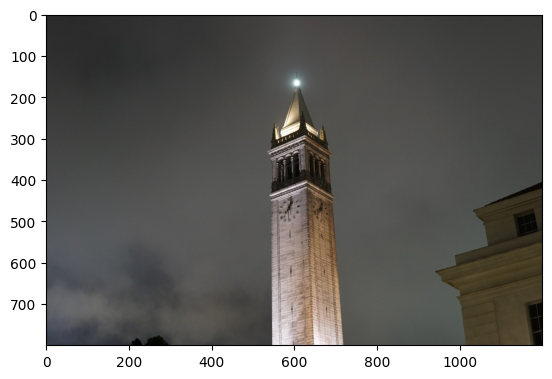

In [148]:
# name of the input file
imname = './source_jpg/Tall_Campanile_1_small.jpg'

# read in the image
im1 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)

imgplot = plt.imshow(im1)

# name of the input file
imname = './source_jpg/Tall_Campanile_2_small.jpg'

# read in the image
im2 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)

imgplot = plt.imshow(im2)

# correspondance points
# name of the input file
f = open('Tall_Campanile_1_small_Tall_Campanile_2_small.json')
correspondances = json.load(f)
f.close()

im1_points = np.array(correspondances["im1Points"])
im2_points = np.array(correspondances["im2Points"])

[[ 9.65145236e-01 -4.43720293e-02  1.34941834e+01]
 [-2.25820878e-02  9.29073991e-01  2.95718081e+02]
 [-8.01997936e-06 -8.67070295e-05  1.00000000e+00]]
(1117, 1258, 3)


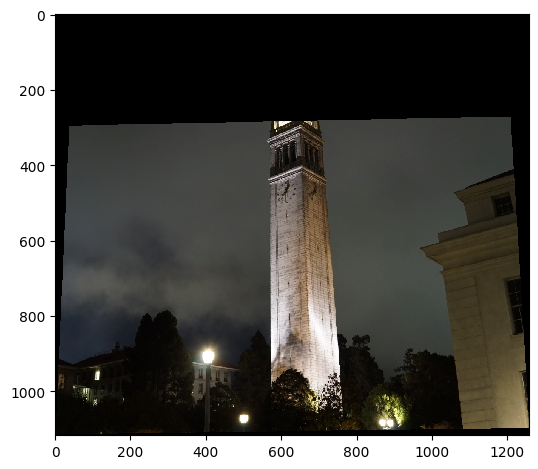

In [149]:
H = computeH(im1_points, im2_points)
print(H)

im1_warp, x_shift, y_shift, im1_mask = warpImage(im1, H)
skio.imshow(im1_warp)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\1505212717.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]


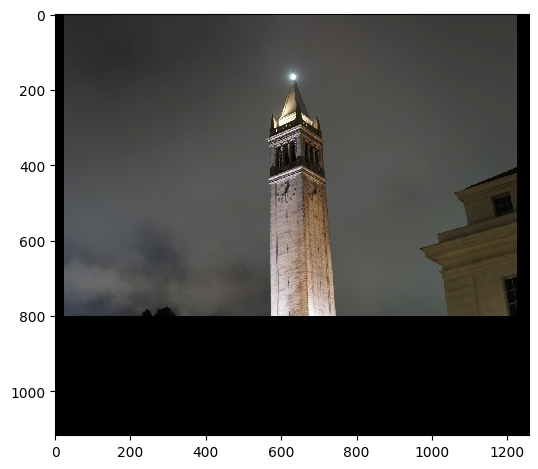

In [150]:
im2_warp = np.zeros([im1_warp.shape[0], im1_warp.shape[1], 3])
im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]
skio.imshow(im2_warp)

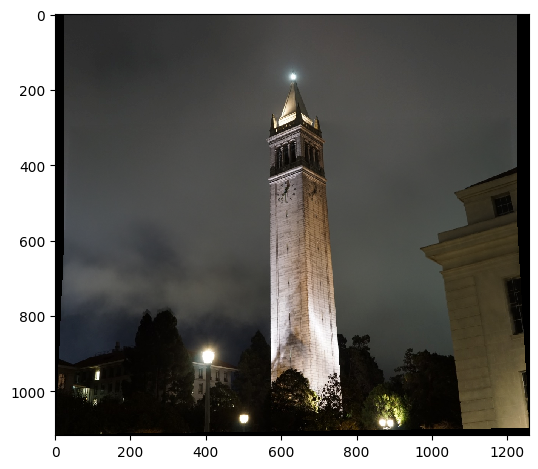

In [151]:
combined = blend(im1_warp, im2_warp)
skio.imshow(combined)
combined = combined*255
combined = combined.astype(np.uint8)
fname = f"./images/combined_vertical_campanile.jpg"
skio.imsave(fname, combined)

In [3]:
# name of the input file
imname = './source_jpg/campanile_1_small.jpg'

# read in the image
im1 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)

# imgplot = plt.imshow(im1)

# name of the input file
imname = './source_jpg/Campanile_2_small.jpg'

# read in the image
im2 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)

# imgplot = plt.imshow(im2)

# correspondance points
# name of the input file
f = open('Campanile_1_small_Campanile_2_small.json')
correspondances = json.load(f)
f.close()

im1_points = np.array(correspondances["im1Points"])
im2_points = np.array(correspondances["im2Points"])

In [ ]:
H = computeH(im1_points, im2_points)
print(H)

im1_warp, x_shift, y_shift, im1_mask = warpImage(im1, H)
skio.imshow(im1_warp)

In [ ]:
im2_warp = np.zeros([im1_warp.shape[0], im1_warp.shape[1], 3])
im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]
skio.imshow(im2_warp)

In [ ]:
combined = blend(im1_warp, im2_warp)
skio.imshow(combined)
combined = combined*255
combined = combined.astype(np.uint8)
fname = f"./images/combined_vlsb_campanile.jpg"
skio.imsave(fname, combined)

# Part B of the project

### Step 1a: Harris Interest Point Detector

In [120]:
# from the Harris.py sample code
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\676854346.py:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


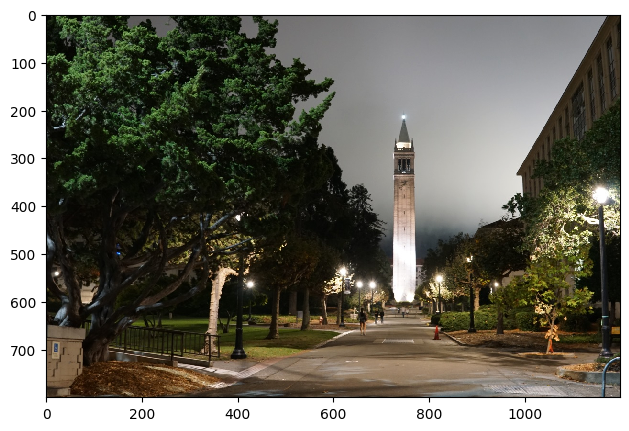

In [15]:
# name of the input file
imname_1 = './source_jpg/Campanile_1_small.jpg'

# read in the image
im1_gray = skio.imread(imname_1, as_gray=True)
im1 = skio.imread(imname_1, as_gray=False)

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)
im1_gray = sk.img_as_float(im1_gray)

skio.imshow(im1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\676854346.py:18: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=1, indices=True)


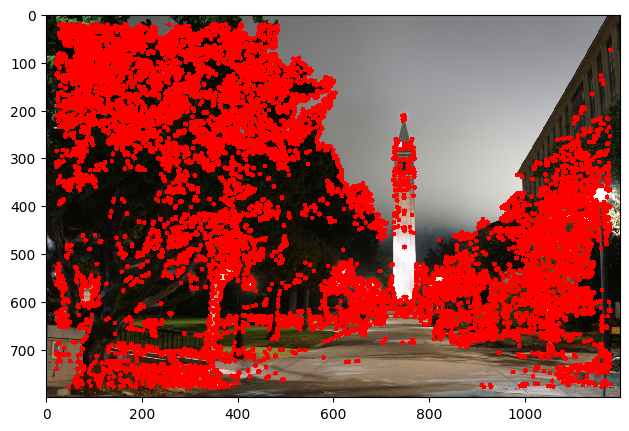

In [16]:
# h = harris values at each pixel, coords = (y, x) of all harris points
h_1, coords_1 = get_harris_corners(im1_gray, edge_discard=20) # use im1_gray since harris corners uses grayscale images

harris_points_1 = []
# threshold was 10 in the paper, we are dividing by 255 since our pixel values are in float
threshold = 10/255
for y, x in zip(coords_1[0], coords_1[1]):
    if h_1[y, x] > threshold:
        harris_points_1.append([y, x])
        cv2.circle(im1, (x, y), 5, (1, 0, 0), -1) # red color circles
skio.imshow(im1)
fname = f"./images/partB/vlsb_campanile_harris_1.jpg"
skio.imsave(fname, (im1*255).astype(np.uint8))
harris_points_1 = np.array(harris_points_1)

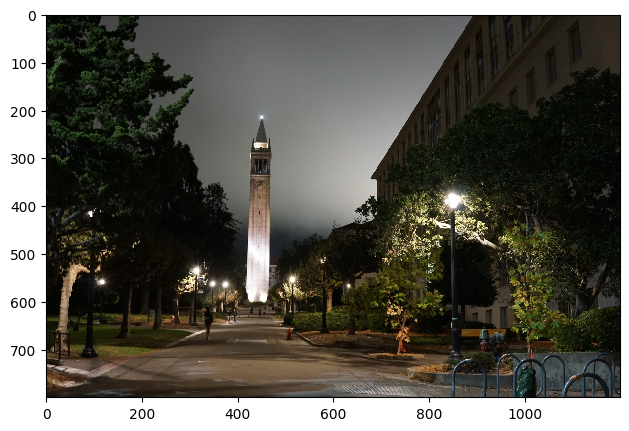

In [17]:
# name of the input file
imname_2 = './source_jpg/Campanile_2_small.jpg'

# read in the image
im2 = skio.imread(imname_2, as_gray=False)
im2_gray = skio.imread(imname_2, as_gray=True)

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)
im2_gray = sk.img_as_float(im2_gray)

skio.imshow(im2)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\676854346.py:18: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=1, indices=True)


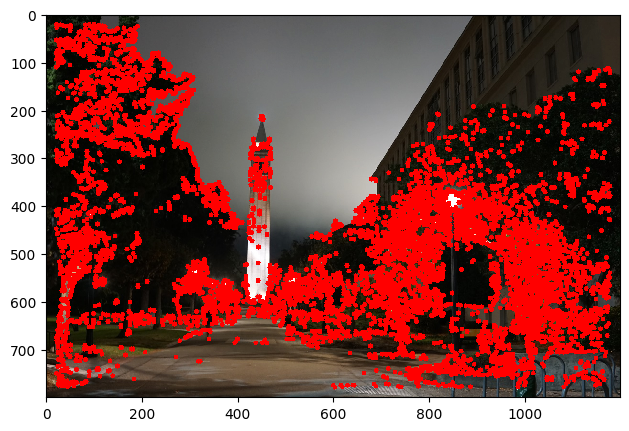

In [18]:
# h = harris values at each pixel, coords = (y, x) of all harris points
h_2, coords_2 = get_harris_corners(im2_gray, edge_discard=20) # use im1_gray since harris corners uses grayscale images

harris_points_2 = []
# threshold was 10 in the paper, we are dividing by 255 since our pixel values are in float
threshold = 10/255
for y, x in zip(coords_2[0], coords_2[1]):
    if h_2[y, x] > threshold:
        harris_points_2.append([y, x])
        cv2.circle(im2, (x, y), 5, (1, 0, 0), -1) # red color circles
skio.imshow(im2)
fname = f"./images/partB/vlsb_campanile_harris_2.jpg"
skio.imsave(fname, (im2*255).astype(np.uint8))
harris_points_2 = np.array(harris_points_2)

### Step 1b: Adaptive Non-Maximal Suppression

In [19]:
def anms(h, harris_points, distances, n):
    # h = corner strength map
    # harris_points = harris corners (y, x) ordered by strength (passed threshold earlier)
    # distances = distance array between each harris point
    # n = number of corners desired

    # array of anms points, insert first point since it is maximal already
    anms_arr = [harris_points[0]]

    # suppresion_radius = min(distances[j])
    # Iterating through list of harris points, starting with r = 0
    for i in range(1, len(harris_points)):
        y, x = harris_points[i]
        # print(y, x)
        # # check if it is within radius of a stronger point
        # if r_mat[y, x] != 0:
        #     break

        # find the minimum suppression radius
        r_i = 0
        sorted = distances[i].copy()
        sorted.sort()
        index = 0
        while r_i == 0:
            if index >= len(sorted):
                break
            dist = sorted[index]
            # print(dist)
            j = np.where(distances[i] == dist) # j-th point in harris_points list
            # print(j)
            # print(harris_points[j, 0], harris_points[j, 1])
            if h[y, x] < 0.9 * h[harris_points[j, 0][0][0], harris_points[j, 1][0][0]]: # h[y_i, x_i] < 0.9*h[y_j, x_j] 
                r_i = dist
            index += 1
        # only appends if the point was maximal within some radius r
        if r_i > 0:
            anms_arr.append([y, x])
    return np.array(anms_arr[:n])

In [20]:
# produces array of distances between each harris_point, where distances[i, j] gives the distance between the i-th and the j-th harris points
distances = dist2(harris_points_1, harris_points_1)
# number of points for anms, 500 used in paper
n = 500

anms_arr_1 = anms(h_1, harris_points_1, distances, n)

In [21]:
# produces array of distances between each harris_point, where distances[i, j] gives the distance between the i-th and the j-th harris points
distances = dist2(harris_points_2, harris_points_2)
# number of points for anms, 500 used in paper
n = 500

anms_arr_2 = anms(h_2, harris_points_2, distances, n)

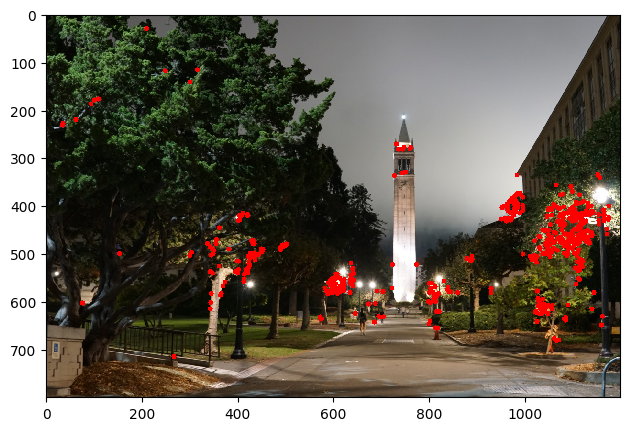

In [22]:
im1 = skio.imread(imname_1, as_gray=False)
im1 = sk.img_as_float(im1)
for y, x in anms_arr_1:
    cv2.circle(im1, (x, y), 5, (1, 0, 0), -1) # red color circles
skio.imshow(im1)
fname = f"./images/partB/vlsb_campanile_anms_1.jpg"
skio.imsave(fname, (im1*255).astype(np.uint8))

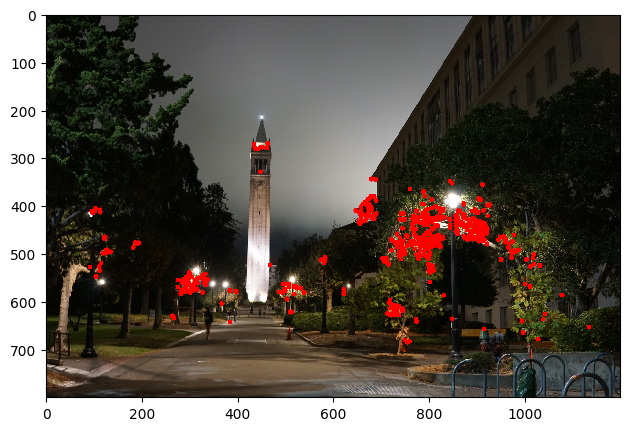

In [23]:
im2 = skio.imread(imname_2, as_gray=False)
im2 = sk.img_as_float(im2)
for y, x in anms_arr_2:
    cv2.circle(im2, (x, y), 5, (1, 0, 0), -1) # red color circles
skio.imshow(im2)
fname = f"./images/partB/vlsb_campanile_anms_2.jpg"
skio.imsave(fname, (im2*255).astype(np.uint8))

### Part 2: Feature Descriptor Extraction

In [24]:
# reload in the images, get rid of red circles
im1 = skio.imread(imname_1, as_gray=False)
im1 = sk.img_as_float(im1)
im2 = skio.imread(imname_2, as_gray=False)
im2 = sk.img_as_float(im2)

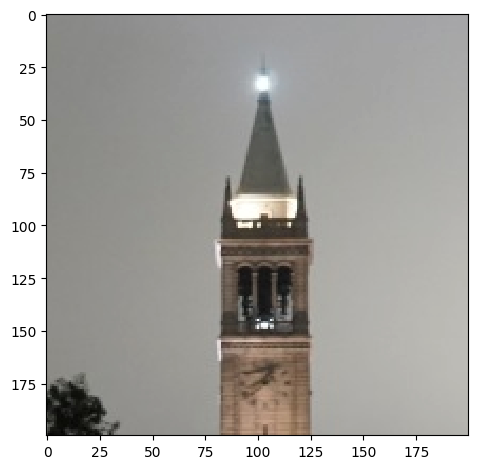

In [38]:
# factor to downscale by
s = 5

y, x = anms_arr_1[40] #(y, x) interest point
# create 40 by 40 patch around sub-pixel location
patch = im1[y-100:y+100, x-100:x+100]
skio.imshow(patch)
fname = f"./images/partB/feature_patch_0.jpg"
skio.imsave(fname, (patch*255).astype(np.uint8))

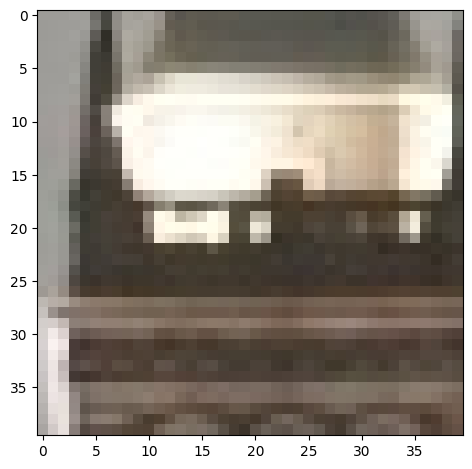

In [39]:
patch = im1[y-20:y+20, x-20:x+20]
skio.imshow(patch)
fname = f"./images/partB/feature_patch_1.jpg"
skio.imsave(fname, (patch*255).astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


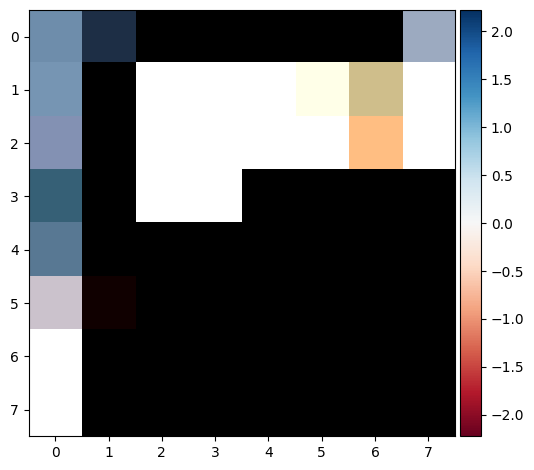

In [40]:
# downsample
patch = cv2.resize(patch, None, fx=1/s, fy=1/s)

# normalize patch
b,g,r = cv2.split(patch)

# compute mean of each channel
bmean = np.mean(b)
gmean = np.mean(g)
rmean = np.mean(r)

# compute std of each channel
bstd = np.std(b)
gstd = np.std(g)
rstd = np.std(r)

patch[:, :, 0] = (patch[:, :, 0] - bmean) / bstd
patch[:, :, 1] = (patch[:, :, 1] - gmean) / gstd
patch[:, :, 2] = (patch[:, :, 2] - rmean) / rstd

skio.imshow(patch)
fname = f"./images/partB/feature_patch_2.jpg"
skio.imsave(fname, (patch*255).astype(np.uint8))

In [42]:
descriptors_1 = []
# factor to downscale by
s = 5

for y, x in anms_arr_1: #(y, x) interest point
    # create 40 by 40 patch around sub-pixel location
    patch = im1[y-20:y+20, x-20:x+20]
    # downsample
    patch = cv2.resize(patch, None, fx=1/s, fy=1/s)

    # normalize patch
    b,g,r = cv2.split(patch)

    # compute mean of each channel
    bmean = np.mean(b)
    gmean = np.mean(g)
    rmean = np.mean(r)

    # compute std of each channel
    bstd = np.std(b)
    gstd = np.std(g)
    rstd = np.std(r)

    patch[:, :, 0] = (patch[:, :, 0] - bmean) / bstd
    patch[:, :, 1] = (patch[:, :, 1] - gmean) / gstd
    patch[:, :, 2] = (patch[:, :, 2] - rmean) / rstd
    
    descriptors_1.append(patch.reshape(-1))
descriptors_1 = np.array(descriptors_1)


descriptors_2 = []
# factor to downscale by
s = 5

for y, x in anms_arr_2: #(y, x) interest point
    # create 40 by 40 patch around sub-pixel location
    patch = im2[y-20:y+20, x-20:x+20]
    # downsample
    patch = cv2.resize(patch, None, fx=1/s, fy=1/s)

    # normalize patch
    b,g,r = cv2.split(patch)

    # compute mean of each channel
    bmean = np.mean(b)
    gmean = np.mean(g)
    rmean = np.mean(r)

    # compute std of each channel
    bstd = np.std(b)
    gstd = np.std(g)
    rstd = np.std(r)

    patch[:, :, 0] = (patch[:, :, 0] - bmean) / bstd
    patch[:, :, 1] = (patch[:, :, 1] - gmean) / gstd
    patch[:, :, 2] = (patch[:, :, 2] - rmean) / rstd

    descriptors_2.append(patch.reshape(-1))
descriptors_2 = np.array(descriptors_2)

### Part 3: Feature Matching

In [43]:
# SDD similarity metric
def sdd(im, ref):
    return np.sum((im-ref)**2)

In [44]:
descriptors_1 = np.float32(descriptors_1)
descriptors_2 = np.float32(descriptors_2)

In [119]:
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)
good = []
for match in matches:
    p = descriptors_1[match[0].queryIdx]
    p1 = descriptors_2[match[0].trainIdx]
    p2 = descriptors_2[match[1].trainIdx]
    d1 = sdd(p, p1)
    d2 = sdd(p, p2)
    if d1/d2 < 0.7:
        good.append([match[0].queryIdx, match[0].trainIdx]) 
matches = np.array(good)

#### Alternate NearestNeighbors implementation, used to check if we get the same number of matching points

In [994]:
# def match_features(features1, features2):
#     # features1, features2 are (500, 64)

#     # find nearest 2 neighbors using SDD metric
#     nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric=sdd).fit(features2)
#     d, idx = nbrs.kneighbors(features1) # 2 nearest neighbors of features1
#     # print(idx[:, 1])
#     matches = np.column_stack((np.arange(features1.shape[0]), idx[:, 0]))
#     # print(matches.shape)
    
#     # calculate 1NN/2NN
#     ratio_confidence = d[:, 0] / d[:, 1]
#     # print(ratio_confidence.shape)
    
#     # threshold = 0.7 as that is where incorrect matchs start becoming more than correct matches
#     indices = np.where(ratio_confidence < 0.7)
#     # print(indices)
    
#     return matches[indices], ratio_confidence

In [995]:
# matches, ratio = match_features(descriptors_1, descriptors_2)

In [46]:
len(matches)

294

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 80


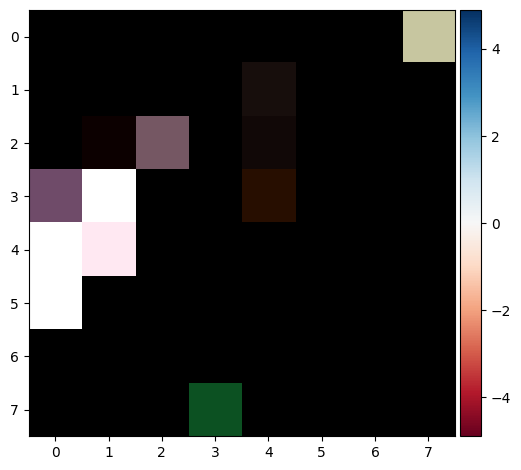

In [47]:
index1, index2 = matches[0]
print(index1, index2)
skio.imshow(descriptors_1[index1].reshape(8, 8, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9.496871


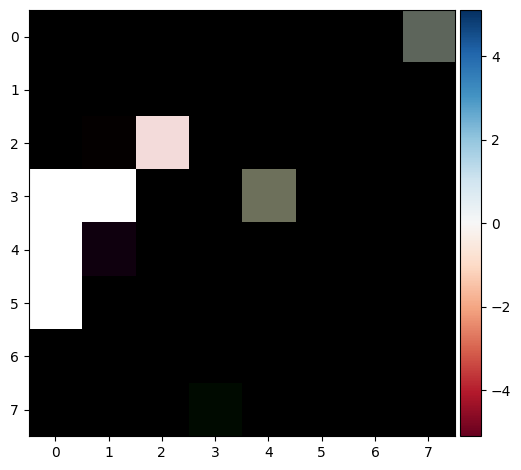

In [48]:
skio.imshow(descriptors_2[index2].reshape(8, 8, 3))
print(sdd(descriptors_1[index1], descriptors_2[index2]))

In [81]:
for index1, index2 in matches:
    y, x = anms_arr_1[index1]
    cv2.circle(im1, (x, y), 5, (1, 0, 0), -1) # blue color circles
    y, x = anms_arr_2[index2]
    cv2.circle(im2, (x, y), 5, (1, 0, 0), -1) # blue color circles

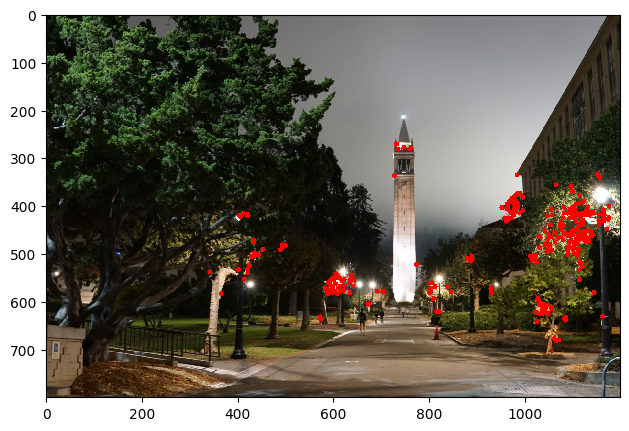

In [82]:
skio.imshow(im1)
fname = f"./images/partB/vlsb_campanile_match_1.jpg"
skio.imsave(fname, (im1*255).astype(np.uint8))

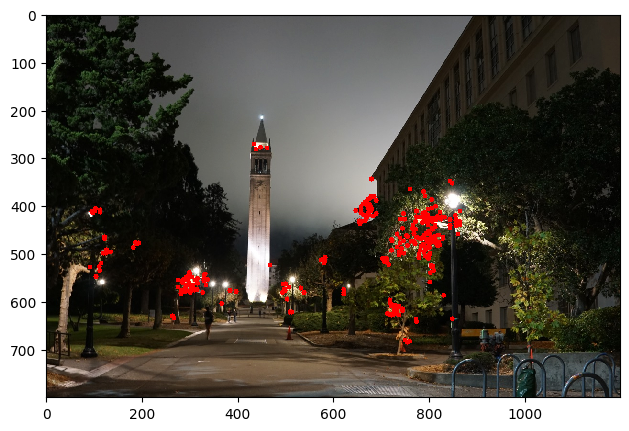

In [83]:
skio.imshow(im2)
fname = f"./images/partB/vlsb_campanile_match_2.jpg"
skio.imsave(fname, (im2*255).astype(np.uint8))

### Part 4: RANSAC

In [52]:
# euclidean distance between 2 points
def euclidean_dist(p1, p2):
    return np.linalg.norm(p1 - p2)

In [105]:
largest_inliers = []
# run loop 100 times
for _ in range(100):
    # Select 4 feature pairs at random
    feature_pairs = np.random.choice(len(matches), 4, replace=False)
    feature_pairs = matches[feature_pairs]
    im1_pts = anms_arr_1[feature_pairs[:, 0]]
    im2_pts = anms_arr_2[feature_pairs[:, 1]]

    # Compute homography H
    H = computeH(im1_pts, im2_pts)

    # Compute inliers where dist(p', Hp) < e
    epsilon = 1e-1
    im1_pts = anms_arr_1[matches[:, 0]]
    im1_pts = np.vstack([im1_pts[:, 0], im1_pts[:, 1], np.ones(len(im1_pts))])
    im2_pts = anms_arr_2[matches[:, 1]]
    im2_pts = np.vstack([im2_pts[:, 0], im2_pts[:, 1], np.ones(len(im2_pts))])
    H_p = H @ im1_pts
    H_p /= H_p[2, :] # normalize
    inliers = []
    for i in range(len(im1_pts[0])):
        # print(im2_pts[:, i], H_p[:, i], euclidean_dist(im2_pts[:, i], H_p[:, i]))
        if euclidean_dist(im2_pts[:2, i], H_p[:2, i]) < epsilon: # euclidean distance on x, y coords
            inliers.append([im1_pts[:2, i], im2_pts[:2, i]])
    inliers = np.array(inliers)

    # keep largest set of inliers
    if len(inliers) > len(largest_inliers):
        largest_inliers = inliers

In [106]:
len(largest_inliers)

8

In [107]:
# reload in the images, get rid of the circles
im1 = skio.imread(imname_1, as_gray=False)
im1 = sk.img_as_float(im1)
im2 = skio.imread(imname_2, as_gray=False)
im2 = sk.img_as_float(im2)

for correspondence in largest_inliers:
    index1, index2 = correspondence
    y, x = index1
    cv2.circle(im1, (int(x), int(y)), 5, (1, 0, 0), -1) # blue color circles
    y, x = index2
    cv2.circle(im2, (int(x), int(y)), 5, (1, 0, 0), -1) # blue color circles

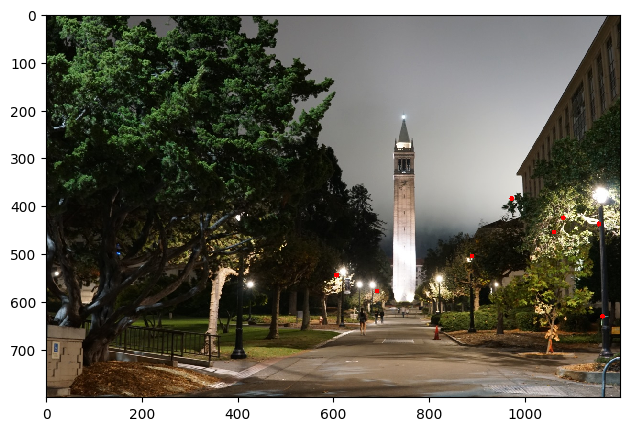

In [108]:
skio.imshow(im1)
fname = f"./images/partB/vlsb_campanile_RANSAC_1.jpg"
skio.imsave(fname, (im1*255).astype(np.uint8))

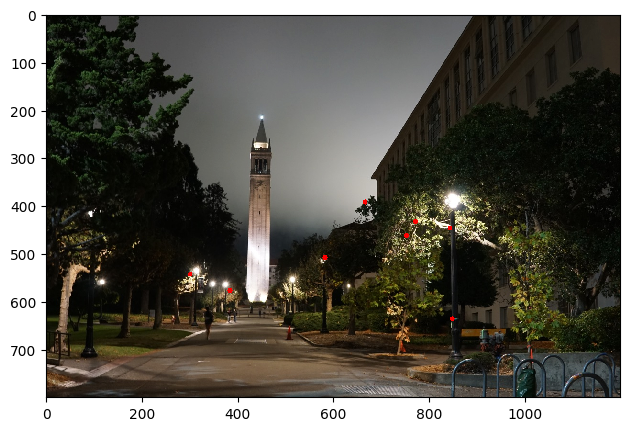

In [109]:
skio.imshow(im2)
fname = f"./images/partB/vlsb_campanile_RANSAC_2.jpg"
skio.imsave(fname, (im2*255).astype(np.uint8))

In [110]:
# recompute least-squares H estimate on all inliers
im1_pts = []
im2_pts = []
for p1, p2 in largest_inliers:
    im1_pts.append([p1[1], p1[0]]) # (x, y) for computeH
    im2_pts.append([p2[1], p2[0]]) # (x, y) for computeH
im1_pts = np.array(im1_pts)
im2_pts = np.array(im2_pts)
H = computeH(im1_pts, im2_pts)
print(H)

[[ 1.00725225e+00 -3.37023715e-02 -2.91752368e+02]
 [ 2.75292807e-02  9.79407795e-01 -6.97270190e+00]
 [ 2.16826281e-05 -2.23960405e-05  1.00000000e+00]]


### Part 5: Producing Mosaics

In [111]:
# name of the input file
imname = './source_jpg/Campanile_1_small.jpg'

# read in the image
im1 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)

# imgplot = plt.imshow(im1)

# name of the input file
imname = './source_jpg/Campanile_2_small.jpg'

# read in the image
im2 = skio.imread(imname)
# im1 = raw.postprocess()

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)

# imgplot = plt.imshow(im2)

(811, 1526, 3)


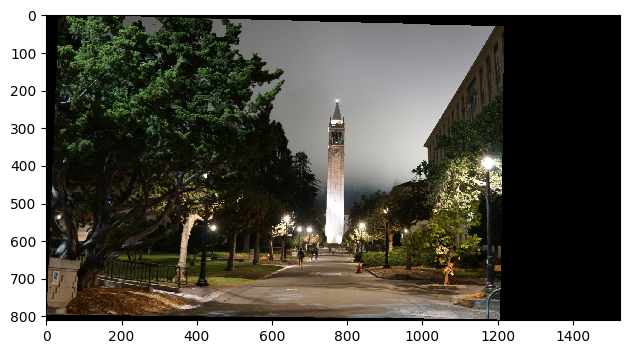

In [112]:
im1_warp, x_shift, y_shift, im1_mask = warpImage(im1, H)
skio.imshow(im1_warp)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\1505212717.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]


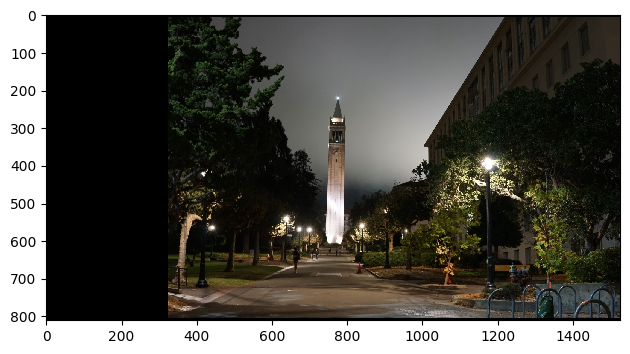

In [113]:
im2_warp = np.zeros([im1_warp.shape[0], im1_warp.shape[1], 3])
im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]
skio.imshow(im2_warp)

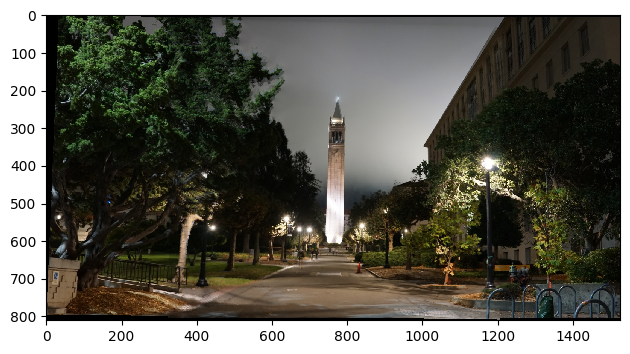

In [114]:
combined = blend(im1_warp, im2_warp)
skio.imshow(combined)

combined = combined*255
combined = combined.astype(np.uint8)
fname = f"./images/partB/combined_vlsb_campanile.jpg"
skio.imsave(fname, combined)

### Other Mosaics

In [124]:
def autostitch(im1, im1_gray, im2, im2_gray):
    # h = harris values at each pixel, coords = (y, x) of all harris points
    h_1, coords_1 = get_harris_corners(im1_gray, edge_discard=20) # use im1_gray since harris corners uses grayscale images

    harris_points_1 = []
    # threshold was 10 in the paper, we are dividing by 255 since our pixel values are in float
    threshold = 10/255
    for y, x in zip(coords_1[0], coords_1[1]):
        if h_1[y, x] > threshold:
            harris_points_1.append([y, x])
    harris_points_1 = np.array(harris_points_1)

    # h = harris values at each pixel, coords = (y, x) of all harris points
    h_2, coords_2 = get_harris_corners(im2_gray, edge_discard=20) # use im1_gray since harris corners uses grayscale images

    harris_points_2 = []
    # threshold was 10 in the paper, we are dividing by 255 since our pixel values are in float
    threshold = 10/255
    for y, x in zip(coords_2[0], coords_2[1]):
        if h_2[y, x] > threshold:
            harris_points_2.append([y, x])
    harris_points_2 = np.array(harris_points_2)

    # produces array of distances between each harris_point, where distances[i, j] gives the distance between the i-th and the j-th harris points
    distances = dist2(harris_points_1, harris_points_1)
    # number of points for anms, 500 used in paper
    n = 500
    anms_arr_1 = anms(h_1, harris_points_1, distances, n)

    # produces array of distances between each harris_point, where distances[i, j] gives the distance between the i-th and the j-th harris points
    distances = dist2(harris_points_2, harris_points_2)
    # number of points for anms, 500 used in paper
    n = 500
    anms_arr_2 = anms(h_2, harris_points_2, distances, n)

    descriptors_1 = []
    # factor to downscale by
    s = 5

    for y, x in anms_arr_1: #(y, x) interest point
        # create 40 by 40 patch around sub-pixel location
        patch = im1[y-20:y+20, x-20:x+20]
        # downsample
        patch = cv2.resize(patch, None, fx=1/s, fy=1/s)

        # normalize patch
        b,g,r = cv2.split(patch)

        # compute mean of each channel
        bmean = np.mean(b)
        gmean = np.mean(g)
        rmean = np.mean(r)

        # compute std of each channel
        bstd = np.std(b)
        gstd = np.std(g)
        rstd = np.std(r)

        patch[:, :, 0] = (patch[:, :, 0] - bmean) / bstd
        patch[:, :, 1] = (patch[:, :, 1] - gmean) / gstd
        patch[:, :, 2] = (patch[:, :, 2] - rmean) / rstd
        
        descriptors_1.append(patch.reshape(-1))
    descriptors_1 = np.array(descriptors_1)


    descriptors_2 = []
    # factor to downscale by
    s = 5

    for y, x in anms_arr_2: #(y, x) interest point
        # create 40 by 40 patch around sub-pixel location
        patch = im2[y-20:y+20, x-20:x+20]
        # downsample
        patch = cv2.resize(patch, None, fx=1/s, fy=1/s)

        # normalize patch
        b,g,r = cv2.split(patch)

        # compute mean of each channel
        bmean = np.mean(b)
        gmean = np.mean(g)
        rmean = np.mean(r)

        # compute std of each channel
        bstd = np.std(b)
        gstd = np.std(g)
        rstd = np.std(r)

        patch[:, :, 0] = (patch[:, :, 0] - bmean) / bstd
        patch[:, :, 1] = (patch[:, :, 1] - gmean) / gstd
        patch[:, :, 2] = (patch[:, :, 2] - rmean) / rstd

        descriptors_2.append(patch.reshape(-1))
    descriptors_2 = np.array(descriptors_2)

    descriptors_1 = np.float32(descriptors_1)
    descriptors_2 = np.float32(descriptors_2)
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)
    good = []
    for match in matches:
        p = descriptors_1[match[0].queryIdx]
        p1 = descriptors_2[match[0].trainIdx]
        p2 = descriptors_2[match[1].trainIdx]
        d1 = sdd(p, p1)
        d2 = sdd(p, p2)
        if d1/d2 < 0.7:
            good.append([match[0].queryIdx, match[0].trainIdx]) 
    matches = np.array(good)

    largest_inliers = []
    # run loop 100 times
    for _ in range(100):
        # Select 4 feature pairs at random
        feature_pairs = np.random.choice(len(matches), 4, replace=False)
        feature_pairs = matches[feature_pairs]
        im1_pts = anms_arr_1[feature_pairs[:, 0]]
        im2_pts = anms_arr_2[feature_pairs[:, 1]]

        # Compute homography H
        H = computeH(im1_pts, im2_pts)

        # Compute inliers where dist(p', Hp) < e
        epsilon = 1e-1
        im1_pts = anms_arr_1[matches[:, 0]]
        im1_pts = np.vstack([im1_pts[:, 0], im1_pts[:, 1], np.ones(len(im1_pts))])
        im2_pts = anms_arr_2[matches[:, 1]]
        im2_pts = np.vstack([im2_pts[:, 0], im2_pts[:, 1], np.ones(len(im2_pts))])
        H_p = H @ im1_pts
        H_p /= H_p[2, :] # normalize
        inliers = []
        for i in range(len(im1_pts[0])):
            # print(im2_pts[:, i], H_p[:, i], euclidean_dist(im2_pts[:, i], H_p[:, i]))
            if euclidean_dist(im2_pts[:2, i], H_p[:2, i]) < epsilon: # euclidean distance on x, y coords
                inliers.append([im1_pts[:2, i], im2_pts[:2, i]])
        inliers = np.array(inliers)

        # keep largest set of inliers
        if len(inliers) > len(largest_inliers):
            largest_inliers = inliers

    # recompute least-squares H estimate on all inliers
    im1_pts = []
    im2_pts = []
    for p1, p2 in largest_inliers:
        im1_pts.append([p1[1], p1[0]]) # (x, y) for computeH
        im2_pts.append([p2[1], p2[0]]) # (x, y) for computeH
    im1_pts = np.array(im1_pts)
    im2_pts = np.array(im2_pts)
    H = computeH(im1_pts, im2_pts)

    im1_warp, x_shift, y_shift, im1_mask = warpImage(im1, H)
    im2_warp = np.zeros([im1_warp.shape[0], im1_warp.shape[1], 3])
    im2_mesh = np.meshgrid(range(im2.shape[0]), range(im2.shape[1])) # (rr, cc)
    im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]
    combined = blend(im1_warp, im2_warp)

    return combined


In [145]:
# name of the input file
imname_1 = './source_jpg/tall_campanile_1_small.jpg'

# read in the image
im1_gray = skio.imread(imname_1, as_gray=True)
im1 = skio.imread(imname_1, as_gray=False)

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)
im1_gray = sk.img_as_float(im1_gray)

# name of the input file
imname_2 = './source_jpg/tall_campanile_2_small.jpg'

# read in the image
im2 = skio.imread(imname_2, as_gray=False)
im2_gray = skio.imread(imname_2, as_gray=True)

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)
im2_gray = sk.img_as_float(im2_gray)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\676854346.py:18: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=1, indices=True)


(1080, 1205, 3)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\2071112800.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]


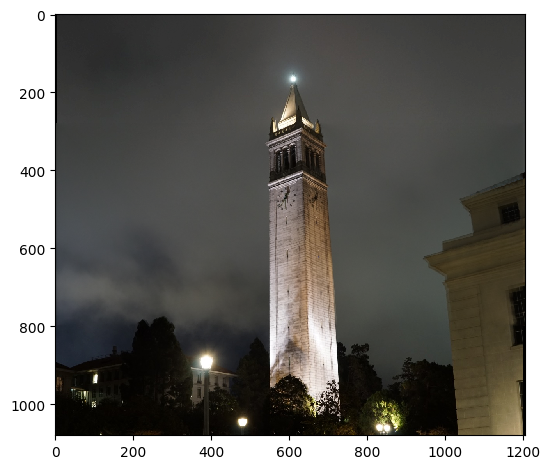

In [146]:
combined = autostitch(im1, im1_gray, im2, im2_gray)
skio.imshow(combined)

In [147]:
combined = combined*255
combined = combined.astype(np.uint8)
fname = f"./images/partB/combined_tall_campanile.jpg"
skio.imsave(fname, combined)

In [140]:
# name of the input file
imname_1 = './source_jpg/glade_1_small.jpg'

# read in the image
im1_gray = skio.imread(imname_1, as_gray=True)
im1 = skio.imread(imname_1, as_gray=False)

# convert to double (might want to do this later on to save memory)    
im1 = sk.img_as_float(im1)
im1_gray = sk.img_as_float(im1_gray)

# name of the input file
imname_2 = './source_jpg/glade_2_small.jpg'

# read in the image
im2 = skio.imread(imname_2, as_gray=False)
im2_gray = skio.imread(imname_2, as_gray=True)

# convert to double (might want to do this later on to save memory)    
im2 = sk.img_as_float(im2)
im2_gray = sk.img_as_float(im2_gray)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\676854346.py:18: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=1, indices=True)


(412, 803, 3)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34288\2071112800.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im2_warp[im2_mesh[0] - y_shift, im2_mesh[1] - x_shift] = im2[im2_mesh]


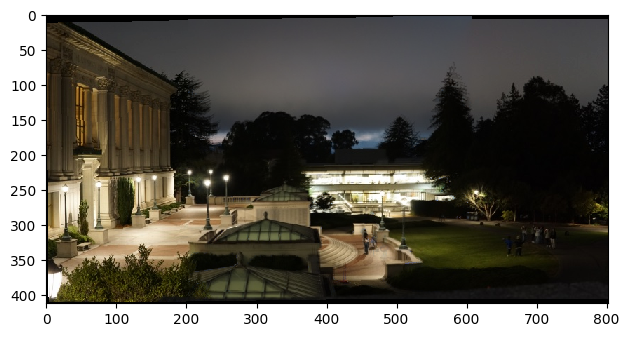

In [142]:
combined = autostitch(im1, im1_gray, im2, im2_gray)
skio.imshow(combined)

In [143]:
combined = combined*255
combined = combined.astype(np.uint8)
fname = f"./images/partB/combined_glade.jpg"
skio.imsave(fname, combined)